<a href="https://colab.research.google.com/github/pkor725/Text-CLassification-with-neural-networks/blob/master/TWITTER_US_AIRLINES_SENTIMENTAL_ANALYSIS_f.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# from __future__ import absolute_import, division, print_function, unicode_literals

# try:
#   # %tensorflow_version only exists in Colab.
#   %tensorflow_version 2.x
# except Exception:
#   pass
# import tensorflow as tf

import numpy as np
import os
import time
import pandas as pd

!pip install tensorflow-hub
!pip install tfds-nightly
import tensorflow_hub as hub
# import tensorflow_datasets as tfds

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [0]:
df = pd.read_csv('/content/Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [0]:
# Checking the shape of the dataset 
df.shape

(14640, 15)

In [0]:
# Checking the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


In [0]:
# Checking for missing values
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [0]:
# Dropping columns with mostly null values
data = df.drop(columns = ['airline_sentiment_gold', 'negativereason_gold', 'tweet_coord'])
data.isnull().sum()

tweet_id                           0
airline_sentiment                  0
airline_sentiment_confidence       0
negativereason                  5462
negativereason_confidence       4118
airline                            0
name                               0
retweet_count                      0
text                               0
tweet_created                      0
tweet_location                  4733
user_timezone                   4820
dtype: int64

In [0]:
# Confirming that missing data on reasons for negative sentiments is limited to positive or neutral tweets
data[data['airline_sentiment'] == 'negative'].isnull().sum()

tweet_id                           0
airline_sentiment                  0
airline_sentiment_confidence       0
negativereason                     0
negativereason_confidence          0
airline                            0
name                               0
retweet_count                      0
text                               0
tweet_created                      0
tweet_location                  3142
user_timezone                   3170
dtype: int64

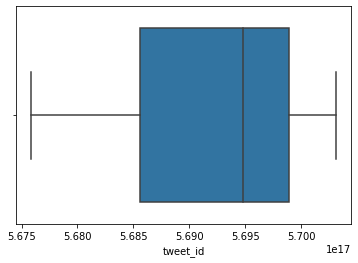

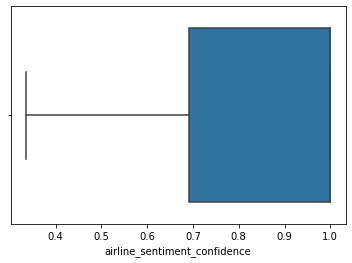

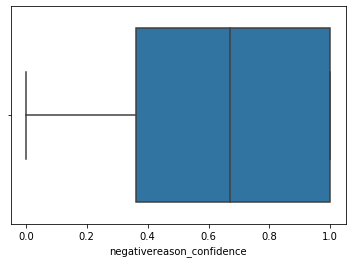

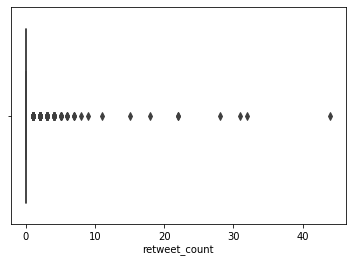

In [0]:
# Checking for outliers with boxplots
import seaborn as sns
import matplotlib.pyplot as plt
numcols = data.select_dtypes(exclude = 'object')

for col in numcols:
  plt.figure()
  sns.boxplot(data[col])

In [0]:
# Checking for duplicated records
data.duplicated().sum()


39

In [0]:
# Dropping duplicates
data.drop_duplicates(keep = 'first', inplace = True)
data.duplicated().sum()

0

In [0]:
# Creating a new dataset with only negative sentiment tweets
df_neg = data[data['airline_sentiment'] == 'negative'][['negativereason', 'text']]
df_neg.head()

,negativereason,text
3,Bad Flight,@VirginAmerica it's really aggressive to blast...
4,Can't Tell,@VirginAmerica and it's a really big bad thing...
5,Can't Tell,@VirginAmerica seriously would pay $30 a fligh...
15,Late Flight,@VirginAmerica SFO-PDX schedule is still MIA.
17,Bad Flight,@VirginAmerica I flew from NYC to SFO last we...


In [0]:
# #removing twitter username(@virginAmerica, its repetitive and might have the training of the model yet it has no significance)
# df_neg['text'] = df_neg['text'].str.replace('\@\w+\s', ' ' )
# #removing punctuations
# df_neg['text'] = df_neg.text.str.replace('<[^>]+>', ' ' )
# df_neg['text'] = df_neg.text.str.replace("\s+[a-zA-Z]\s+", ' ' )
# # Remove punctuations and numbers
# df_neg['text']  = df_neg.text.str.replace('[^a-zA-Z]', ' ')
# # Removing multiple spaces
# df_neg['text'] = df_neg['text'].str.replace(r'\s+', ' ')
# # Converting all characters in the message to lower case
# df_neg['text'] = df_neg['text'].map(lambda x: x.lower())
# #removing single indpendent letters
# df_neg['text'] = df_neg['text'].str.replace('\s\w\s', ' ')
# df_neg.head()

In [0]:
# extracting negative tweets to csv file
df_neg.to_csv('negative_tweets.csv')

In [0]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_neg['negativereason'] = le.fit_transform(df_neg['negativereason'])


3     0
4     1
5     1
15    7
17    0
Name: negativereason, dtype: int64

In [0]:
# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords


In [0]:
# Splitting the tweets and labels into train and test sets
train_text, test_text, train_y, test_y = train_test_split(df_neg['text'],df_neg['negativereason'],test_size = 0.2)

Preprocessing text for the (supervised) CBOW model
We will implement a simple classification model in Keras. Raw text requires (sometimes a lot of) preprocessing.

The following cells uses Keras to preprocess text:

using a tokenizer. You may use different tokenizers (from scikit-learn, NLTK, custom Python function etc.). This converts the texts into sequences of indices representing the 20000 most frequent words
sequences have different lengths, so we pad them (add 0s at the end until the sequence is of length 1000)
we convert the output classes as 1-hot encodings

In [0]:
train_text.shape

(7325,)

In [0]:
 MAX_NB_WORDS = 10000
from keras.preprocessing.text import Tokenizer
# get the raw text data
texts_train = train_text.astype(str)
texts_test = test_text.astype(str)

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS, char_level=False)
tokenizer.fit_on_texts(texts_train)
sequences = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 9836 unique tokens.


In [0]:
sequences[0]

[22,
 3,
 402,
 4390,
 86,
 408,
 40,
 31,
 165,
 275,
 113,
 655,
 294,
 33,
 1155,
 8,
 1301,
 16,
 490,
 116,
 304,
 1540]

The tokenizer object stores a mapping (vocabulary) from word strings to token ids that can be inverted to reconstruct the original message (without formatting):

In [0]:
type(tokenizer.word_index), len(tokenizer.word_index)

(dict, 9836)

In [0]:
index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())
" ".join([index_to_word[i] for i in sequences[0]])

"southwestair i always brag about ur service but very disappointed today apparently i'll be sleeping on floor of dallas airport tonight 👎"

Let's have a closer look at the tokenized sequences:



In [0]:
seq_lens = [len(s) for s in sequences]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))

average length: 20.0
max length: 36


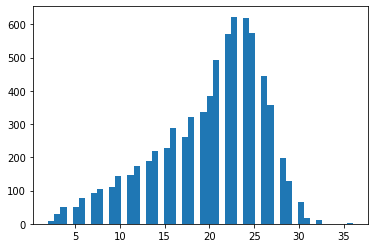

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(seq_lens, bins=50);

In [0]:
from keras.preprocessing.sequence import pad_sequences

MAX_SEQUENCE_LENGTH = 150

# pad sequences with 0s
x_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', x_train.shape)
print('Shape of data test tensor:', x_test.shape)

Shape of data tensor: (7325, 150)
Shape of data test tensor: (1832, 150)


In [0]:
from keras.utils.np_utils import to_categorical
y_train = train_y
y_test = test_y

y_train = to_categorical(np.asarray(y_train))
print('Shape of label tensor:', y_train.shape)

Shape of label tensor: (7325, 10)


In [0]:
# from tensorflow.python.keras.layers import Dense
# from tensorflow.python.keras import Sequential
# from keras.layers import Dense, Input, Flatten
!pip install tensorflow==1.14.0


In [0]:
from keras.layers import Dense, Input, Flatten
from keras.layers import GlobalAveragePooling1D, Embedding
from keras.models import Model

EMBEDDING_DIM = 150
N_CLASSES = 10

# input: a sequence of MAX_SEQUENCE_LENGTH integers

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences = embedding_layer(sequence_input)

average = GlobalAveragePooling1D()(embedded_sequences)
predictions = Dense(N_CLASSES, activation='softmax')(average)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['acc'])

In [0]:
model.fit(x_train, y_train, validation_split=0.1,
          nb_epoch=40, batch_size=128)

Train on 6592 samples, validate on 733 samples
Epoch 1/40
 768/6592 [==>...........................] - ETA: 1s - loss: 1.0215 - acc: 0.6979

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


6592/6592 [==============================] - 1s 188us/step - loss: 1.0168 - acc: 0.7013 - val_loss: 1.3078 - val_acc: 0.5675
Epoch 2/40
6592/6592 [==============================] - 1s 198us/step - loss: 0.9891 - acc: 0.7051 - val_loss: 1.2989 - val_acc: 0.5784
Epoch 3/40
6592/6592 [==============================] - 1s 211us/step - loss: 0.9633 - acc: 0.7219 - val_loss: 1.2904 - val_acc: 0.5798
Epoch 4/40
6592/6592 [==============================] - 1s 187us/step - loss: 0.9377 - acc: 0.7319 - val_loss: 1.2784 - val_acc: 0.5798
Epoch 5/40
6592/6592 [==============================] - 1s 189us/step - loss: 0.9126 - acc: 0.7426 - val_loss: 1.2760 - val_acc: 0.5894
Epoch 6/40
6592/6592 [==============================] - 1s 187us/step - loss: 0.8886 - acc: 0.7532 - val_loss: 1.2659 - val_acc: 0.5894
Epoch 7/40
6592/6592 [==============================] - 1s 187us/step - loss: 0.8656 - acc: 0.7599 - val_loss: 1.2559 - val_acc: 0.5894
Epoch 8/40
6592/6592 [==============================] - 1s 

In [0]:
# input: a sequence of MAX_SEQUENCE_LENGTH integers
from keras.layers import LSTM, Conv1D, MaxPooling1D, Dropout
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

x = LSTM(128, dropout=0.2, recurrent_dropout=0.2)(embedded_sequences)
predictions = Dense(10, activation='softmax')(x)


model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [0]:
model.fit(x_train, y_train, validation_split=0.1,
          nb_epoch=8, batch_size=128)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 6592 samples, validate on 733 samples
Epoch 1/8
6592/6592 [==============================] - 46s 7ms/step - loss: 0.0761 - acc: 0.9756 - val_loss: 2.4217 - val_acc: 0.5853
Epoch 2/8
6592/6592 [==============================] - 46s 7ms/step - loss: 0.0685 - acc: 0.9789 - val_loss: 2.5248 - val_acc: 0.5771
Epoch 3/8
6592/6592 [==============================] - 45s 7ms/step - loss: 0.0632 - acc: 0.9804 - val_loss: 2.4182 - val_acc: 0.5880
Epoch 4/8
6592/6592 [==============================] - 44s 7ms/step - loss: 0.0562 - acc: 0.9835 - val_loss: 2.6760 - val_acc: 0.5662
Epoch 5/8
6592/6592 [==============================] - 44s 7ms/step - loss: 0.0518 - acc: 0.9850 - val_loss: 2.5902 - val_acc: 0.5839
Epoch 6/8
6592/6592 [==============================] - 43s 6ms/step - loss: 0.0477 - acc: 0.9853 - val_loss: 2.6946 - val_acc: 0.5771
Epoch 7/8
6592/6592 [==============================] - 41s 6ms/step - loss: 0.0469 - acc: 0.9856 - val_loss: 2.7394 - val_acc: 0.5825
Epoch 8/8
6592/

In [0]:
embedding = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)
hub_layer(train_text)


# hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                          #  dtype=tf.string, trainable=True)
# hub_layer(x_test)

<tf.Tensor: shape=(7325, 50), dtype=float32, numpy=
array([[ 0.23209932,  0.09930316, -0.16737647, ..., -0.16813202,
         0.08097278,  0.44308537],
       [ 0.4194339 , -0.18075328, -0.23868965, ..., -0.16100903,
        -0.01291952,  0.29614103],
       [ 0.5074602 ,  0.11622936, -0.23083562, ..., -0.21178815,
        -0.08915531,  0.12203416],
       ...,
       [ 0.42551106, -0.06255901,  0.0021237 , ..., -0.13290864,
        -0.03075016,  0.22596468],
       [ 0.11743198, -0.20251235, -0.15701696, ..., -0.11113952,
         0.09976719,  0.1921778 ],
       [ 0.3348192 ,  0.05176795,  0.15665843, ..., -0.2740065 ,
         0.10084584,  0.10243692]], dtype=float32)>